In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os

%matplotlib inline

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9194532507529919557
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6705216225
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7123710772436939135
physical_device_desc: "device: 0, name: Quadro P4000, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


In [55]:
train_x = pd.read_csv('input/train_x.csv', index_col=0, header=None)
train_y = pd.read_csv('input/train_y.csv', index_col=0)
test_x = pd.read_csv('input/test_x.csv', index_col=0, header=None)

In [56]:
test_x.shape

(4800, 3072)

In [57]:
import matplotlib
matplotlib.use("Agg")
 
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import os
# from keras.utils import np_utils
import gc 

import pandas as pd 
import matplotlib.pyplot as plt 
import os
from keras.utils import np_utils

%matplotlib inline

In [216]:
EPOCHS = 100
INIT_LR = 1e-3
IMAGE_DIMS = (32 , 32 , 3)
BATCH_SIZE = 200
SIZE_DF = df.map.shape[0]

In [59]:
mappping_type = {'Bird': 0, 'Airplane': 1}
train_y_bin = train_y.replace({"target": mappping_type})

In [60]:
d1 = [[np.array(x)] for x in train_x.values]
d = {'map': d1, 'target': train_y_bin.target}

In [61]:
df = pd.DataFrame(data=d)

In [62]:
df.map.shape

(7200,)

In [63]:
df.head()

,map,target
0,"[[4, 20, 18, 4, 16, 15, 2, 11, 9, 2, 6, 5, 1, ...",0
1,"[[109, 155, 233, 109, 155, 231, 110, 156, 232,...",1
2,"[[156, 172, 195, 158, 174, 197, 158, 174, 197,...",1
3,"[[115, 108, 52, 97, 100, 79, 86, 107, 98, 79, ...",1
4,"[[167, 205, 221, 160, 198, 213, 161, 198, 214,...",1


In [155]:
train_df.target.values.shape

(5760,)

In [181]:
def make_image_gen_cat(in_df, batch_size=BATCH_SIZE):
    all_batches = in_df.sample(frac=1)
    out_map = []
    out_class = []
    size = in_df.shape[0]
    indexes = np.random.randint(0, size, size)
    while True:
        for index in indexes:
            out_map += [in_df.map.values[index][0]/255.]
            out_class += [in_df.target.values[index]]
            if len(out_map) >= batch_size:
                out_map = np.array(out_map)
                out_map = out_map.reshape(out_map.shape[0], IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2])
                yield np.stack(out_map, 0), np.array(np_utils.to_categorical(out_class, num_classes=2))
                out_map = []
                out_class = []

In [182]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)
train_df.shape[0], valid_df.shape[0]

(5760, 1440)

In [224]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               rotation_range = 15, 
               width_shift_range = 0.1, 
               height_shift_range = 0.1, 
               shear_range = 0.01,
               zoom_range = [0.9, 1.25])

# dg_args = dict(featurewise_center = False, 
#                samplewise_center = False,
#                rotation_range = 5, 
#                width_shift_range = 0.1, 
#                height_shift_range = 0.1)


image_gen = ImageDataGenerator(**dg_args)
def create_aug_gen(in_gen, seed=None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        g_x = image_gen.flow(255*in_x, 
                             batch_size=in_x.shape[0])

        yield next(g_x)/255., in_y

In [225]:
train_gen = make_image_gen_cat(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape)
print('y', train_y.shape)
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)

gc.collect()

x (20, 32, 32, 3)
y (20, 2)


240

(20, 32, 32, 3) (20, 2)
[0. 1.]
Wall time: 15.9 ms


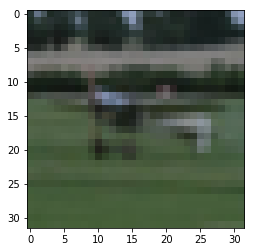

In [226]:
%%time
valid_x, valid_y = next(make_image_gen_cat(train_df))
print(valid_x.shape, valid_y.shape)

n = 16
plt.imshow(valid_x[n,:,:])
print(valid_y[n])

In [208]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.utils import np_utils

In [227]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes, finalAct="softmax"):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same", 
                         input_shape=(IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2])))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(48, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(48, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.3))

#                 # (CONV => RELU) * 2 => POOL
#         model.add(Conv2D(128, (3, 3), padding="same"))
#         model.add(Activation("relu"))
#         model.add(BatchNormalization())
#         model.add(Conv2D(128, (3, 3), padding="same"))
#         model.add(Activation("relu"))
#         model.add(BatchNormalization())
#         model.add(Conv2D(128, (3, 3), padding="same"))
#         model.add(Activation("relu"))
#         model.add(BatchNormalization())
#         model.add(MaxPooling2D(pool_size=(3, 3)))
#         model.add(Dropout(0.4))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # use a *softmax* activation for single-label classification
        # and *sigmoid* activation for multi-label classification
        model.add(Dense(classes))
        
        model.add(Activation(finalAct))

        # return the constructed network architecture
        return model

In [228]:
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
                            depth=IMAGE_DIMS[2], classes=2, 
                            finalAct="sigmoid")
 
# initialize the optimizer
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [229]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_84 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_85 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 32, 32, 32)        9248      
__________

In [230]:
from keras.callbacks import Callback
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, dice_coef, acc, _ = self.model.evaluate(x, y, verbose=0)
        print('\n - Testing loss: {:.4f} - dice_coef: {:.4f} - acc: {:.4f}\n'.format(loss, dice_coef, acc))

In [231]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="C:\\Users\\user\\Python_Code\\Kaggle\\Plane&Bird\\strong_weights_2.h5"
# weight_path = ''
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=10)



callbacks_list = [checkpoint, reduceLROnPlat, early]

gc.collect()

2575

In [234]:
from keras import metrics
from keras import backend as K

model.compile(optimizer=Adam(1e-3, decay=1e-6), 
              loss="categorical_crossentropy",
              metrics=["accuracy", 
                      metrics.categorical_accuracy])

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
reset_weights(model)

In [235]:
gen_train_cat = make_image_gen_cat(train_df)
gen_valid_cat = make_image_gen_cat(valid_df)

aug_gen_cat = create_aug_gen(make_image_gen_cat(train_df))


net = model.fit_generator(gen_train_cat,
                          steps_per_epoch = 100,
                          epochs = 100,
                          validation_data = gen_valid_cat,
                          validation_steps = 100,
                          callbacks = callbacks_list,
                          workers=1, 
                          verbose = 1)

Epoch 1/100
100/100 [==============================] - 8s 80ms/step - loss: 0.6078 - acc: 0.7340 - categorical_accuracy: 0.7340 - val_loss: 0.9152 - val_acc: 0.6780 - val_categorical_accuracy: 0.6780

Epoch 00001: val_acc improved from 0.53500 to 0.67800, saving model to C:\Users\user\Python_Code\Kaggle\Plane&Bird\strong_weights_2.h5
Epoch 2/100
100/100 [==============================] - 4s 38ms/step - loss: 0.4588 - acc: 0.8030 - categorical_accuracy: 0.8030 - val_loss: 0.4681 - val_acc: 0.8100 - val_categorical_accuracy: 0.8100

Epoch 00002: val_acc improved from 0.67800 to 0.81000, saving model to C:\Users\user\Python_Code\Kaggle\Plane&Bird\strong_weights_2.h5
Epoch 3/100
100/100 [==============================] - 4s 38ms/step - loss: 0.4401 - acc: 0.8165 - categorical_accuracy: 0.8165 - val_loss: 0.5979 - val_acc: 0.8030 - val_categorical_accuracy: 0.8030

Epoch 00003: val_acc did not improve from 0.81000
Epoch 4/100
100/100 [==============================] - 4s 42ms/step - loss: 0

100/100 [==============================] - 4s 43ms/step - loss: 0.0898 - acc: 0.9625 - categorical_accuracy: 0.9625 - val_loss: 0.3892 - val_acc: 0.8725 - val_categorical_accuracy: 0.8725

Epoch 00029: val_acc did not improve from 0.88700
Epoch 30/100
100/100 [==============================] - 4s 42ms/step - loss: 0.0836 - acc: 0.9630 - categorical_accuracy: 0.9630 - val_loss: 0.3568 - val_acc: 0.8815 - val_categorical_accuracy: 0.8815

Epoch 00030: val_acc did not improve from 0.88700
Epoch 31/100
100/100 [==============================] - 4s 43ms/step - loss: 0.0854 - acc: 0.9650 - categorical_accuracy: 0.9650 - val_loss: 0.3527 - val_acc: 0.8730 - val_categorical_accuracy: 0.8730

Epoch 00031: val_acc did not improve from 0.88700

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.2914679791720119e-06.
Epoch 32/100
100/100 [==============================] - 4s 41ms/step - loss: 0.0918 - acc: 0.9640 - categorical_accuracy: 0.9640 - val_loss: 0.3973 - val_acc: 0.8620 - val_cat

In [236]:
gen_train_cat = create_aug_gen(make_image_gen_cat(train_df))
gen_valid_cat = create_aug_gen(make_image_gen_cat(valid_df))

aug_gen_cat = create_aug_gen(make_image_gen_cat(train_df))


net = model.fit_generator(gen_train_cat,
                          steps_per_epoch = 100,
                          epochs = 100,
                          validation_data = gen_valid_cat,
                          validation_steps = 100,
                          callbacks = callbacks_list,
                          workers=1, 
                          verbose = 1)

Epoch 1/100
100/100 [==============================] - 4s 40ms/step - loss: 2.6590 - acc: 0.5080 - categorical_accuracy: 0.5080 - val_loss: 2.3789 - val_acc: 0.5175 - val_categorical_accuracy: 0.5175

Epoch 00001: val_acc did not improve from 0.88700
Epoch 2/100
100/100 [==============================] - 4s 40ms/step - loss: 2.5767 - acc: 0.5075 - categorical_accuracy: 0.5075 - val_loss: 2.3424 - val_acc: 0.5175 - val_categorical_accuracy: 0.5175

Epoch 00002: val_acc did not improve from 0.88700
Epoch 3/100
100/100 [==============================] - 4s 40ms/step - loss: 2.3972 - acc: 0.5240 - categorical_accuracy: 0.5240 - val_loss: 2.2283 - val_acc: 0.5090 - val_categorical_accuracy: 0.5090

Epoch 00003: val_acc did not improve from 0.88700
Epoch 4/100
100/100 [==============================] - 4s 40ms/step - loss: 2.3265 - acc: 0.5110 - categorical_accuracy: 0.5110 - val_loss: 2.0741 - val_acc: 0.5190 - val_categorical_accuracy: 0.5190

Epoch 00004: val_acc did not improve from 0.88

In [237]:

# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = len(history.epoch)
plt.plot(np.arange(0, N), net.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), net.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), net.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), net.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

NameError: name 'history' is not defined

<Figure size 432x288 with 0 Axes>

In [51]:
[2*i for i in range(10)]

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

In [238]:
test_x = pd.read_csv('input/test_x.csv', index_col=0, header=None)
test_d1 = [[np.array(x)] for x in test_x.values]
test_d1 = {'map': test_d1}
test = pd.DataFrame(data=test_d1)

In [239]:
out_map = []
out_class = []
for index, row in test.iterrows():
    out_map += [pd.Series(row).values[0][0]]

out_map = np.array(out_map)
out_map = out_map.reshape(out_map.shape[0], IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2])
out_map = np.stack(out_map, 0)

In [240]:
%%time
y_test_pred = model.predict(out_map)

print(y_test_pred.shape)

(4800, 2)
Wall time: 2.26 s


In [241]:
%%time
y_test_pred = model.predict(out_map)

print(y_test_pred.shape)

df = np.array([[i, x.argmax()] for i, x in enumerate(y_test_pred)])
sample = pd.DataFrame(df, columns=['id', 'target'])

mappping_type_inv = {0: 'Bird', 1: 'Airplane'}
sample = sample.replace({'target': mappping_type_inv})

sample.to_csv('output/submit_12.csv', index=False)

(4800, 2)
Wall time: 1.29 s


In [44]:
sample.head()

NameError: name 'sample' is not defined

In [33]:
sample.to_csv('output/submit_12.csv', index=False)

NameError: name 'sample' is not defined